In [1]:
%matplotlib inline
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
from matplotlib import patches
import pandas as pd
from pandas import DataFrame

import math
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.ndimage.filters import gaussian_filter1d

#seting up some styles
import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid")
nb_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# Name defs

L_AWS = "AWS Lambda"
L_GCF = "Google Cloud Functions"
L_IBM = "IBM Cloud Functions"
L_Azure = "Microsoft Azure Functions %s"

shortNames = {L_AWS:"AWS",L_GCF:"GCF",L_IBM:"ICF",L_Azure%"Windows":"MAF (Win.)",L_Azure%"Linux":"MAF (Linux)"}
def shortName(name):
    return shortNames[name]

In [3]:
csvHeader=['timestamp', 'latency', 'protocol', 'code', 'status', 'thread', 'response' , 'version','value','latency2','statusCode','vm_id','boot_time','memory', 'timeout']

awsCode = pd.read_csv('AWS/Results/aws-results-code.csv', names=csvHeader)
azureCodeLinux = pd.read_csv('Azure/Results/azure-linux-results-code.csv', names=csvHeader)
gcloudCode = pd.read_csv('Google/Results/gcloud-results-code.csv', names=csvHeader)
ibmCode = pd.read_csv('IBM/Results/ibm-results-code.csv', names=csvHeader)
azureCodeWindows = pd.read_csv('Azure/Results/azure-windows-results-code.csv', names=csvHeader)

awsConfig = pd.read_csv('AWS/Results/aws-results-config.csv', names=csvHeader)
gcloudConfig = pd.read_csv('Google/Results/gcloud-results-config.csv', names=csvHeader)
ibmConfig = pd.read_csv('IBM/Results/ibm-results-config.csv', names=csvHeader)


In [5]:
def prepare_data(data):

    def idx(a,e):
        return np.where(a==e)[0][0]
    
    data['elapsed_time'] = (data['timestamp'] - min(data['timestamp']))/1000
    data = data.sort_values(by=['timestamp'])
    data['version'] =np.where(data['version'], '1', '2')
    data=data.reset_index(drop=True)

    bt = data["boot_time"].unique()
    bt_map = {}
    for t in bt:
        bt_map[t] = idx(bt,t)


    k = [1] * len(data.index)
    for i in range(1,len(data.index)):
         k[i] = bt_map[data["boot_time"][i]]
    data['instance'] = k

    cid = data["vm_id"].unique()
    cid_map = {}
    for t in cid:
        cid_map[t] = idx(cid,t)

    k = [1] * len(data.index)
    for i in range(1,len(data.index)):
         k[i] = cid_map[data["vm_id"][i]]
    data['container'] = k
    
    
    
    container_count = data.groupby("timestamp")["container"].count()
    container_count = container_count.to_dict()
    k = [1] * len(data.index)
    for i in range(1,len(data.index)):
        k[i] = container_count[data["timestamp"][i]]
    data['num_container'] = k
    
    instance_count = data.groupby("timestamp")["instance"].count()
    instance_count = instance_count.to_dict()
    k = [1] * len(data.index)
    for i in range(1,len(data.index)):
        k[i] = container_count[data["timestamp"][i]]
        
    
    container_count = data.groupby("timestamp")["container"].max()
    container_count = container_count.to_dict()
    k = [1] * len(data.index)
    for i in range(1,len(data.index)):
        k[i] = container_count[data["timestamp"][i]]
    data['new_container'] = k
    
    instance_count = data.groupby("timestamp")["instance"].max()
    instance_count = instance_count.to_dict()
    k = [1] * len(data.index)
    for i in range(1,len(data.index)): 
        k[i] = container_count[data["timestamp"][i]]

    data['new_instance'] = k
    
    
    
    k = [1] * len(data.index)
    if not math.isnan(data["memory"].max()):
        
        mmax = np.math.floor(data["memory"].max())
        tmax = np.math.floor(data["timeout"].max())
        for i in range(1,len(data.index)): 
            if data["memory"][i] >= mmax and data["timeout"][i] >= tmax:
                k[i] = '1'
    #         if data["memory"][i] >= mmax and data["timeout"][i] < tmax:
    #             k[i] = 3
    #         if data["memory"][i] < mmax and data["timeout"][i] < tmax:
    #             k[i] = 4
            else:
                k[i] = '2'
        
        
    data['config'] = k
    
    return data


In [5]:
def plot_data(data,label,plot):

    plot.set_title(label)
    plot.plot(data.loc[data['statusCode'] == 200]['elapsed_time'], data.loc[data['statusCode'] == 200]['latency'], color=nb_colors[1],marker='x', markersize=4, label='Existing Instance', linewidth=0)
    plot.plot(data.loc[data['statusCode'] == 201]['elapsed_time'], data.loc[data['statusCode'] == 201]['latency'], color=nb_colors[2],marker='o', markersize=6, label='New Instance', linewidth=0)
    plot.plot(data.loc[data['statusCode'] == 400]['elapsed_time'], data.loc[data['statusCode'] == 400]['latency'], color=nb_colors[3],marker='*', markersize=6, label='Failed Request', linewidth=0)
    plot.yaxis.set_ticks_position('both')
    plotInstance = plot.twinx()
    
    smoothedInstance = gaussian_filter1d(data['new_container'], sigma=3)
    plotInstance.plot(data['elapsed_time'], smoothedInstance, color=nb_colors[6], label='Unique Instances', linewidth=1)
    
    plot.vlines(30,0,data['latency'].max(),linestyles='dashed',color="teal",label='Time of Update')
    if label=='Microsoft Azure Windows Function App Code Change' :
        plotInstance.legend(loc='center right')
        plot.legend(loc='upper left')

    print(label + ' average latency is ' + str(round(sum(data['latency'])/len(data['latency']),2)))


In [636]:
def plot_staleness(data,label,plot):

    plot.set_title(label)
    plot.xaxis.grid(True)

    t_visibility=round(max(data.loc[data['version'] == '1']['elapsed_time']) - min(data.loc[data['version'] == '2']['elapsed_time']),1)
    plot.plot(data['elapsed_time'][int(0*len(data['elapsed_time'])/5): int(5*len(data['elapsed_time'])/5)], data['version'][int(0*len(data['elapsed_time'])/5): int(5*len(data['elapsed_time'])/5)], color='black',label='t-Visibilty=' + str(t_visibility)+'s', markersize=4, marker='x', linewidth=0)
    plot.legend(markerscale =0,loc='center right', fontsize=14)
    print (label +' time to propagate is '+ str (round(min(data.loc[data['version'] == '2']['elapsed_time']) -30,3)))
    

    return True

In [637]:
def plot_staleness_config(data,label,plot,configType):

    plot.set_title(label)
    plot.xaxis.grid(True)
    v1_config = data[configType][0]
    v2_config = data[configType][len(data[configType])-1]
    
    t_visibility=round(max(data.loc[data[configType] == v1_config]['elapsed_time']) - min(data.loc[data[configType] == v2_config]['elapsed_time']),1)
    plot.plot(data['elapsed_time'][int(0*len(data['elapsed_time'])/5): int(5*len(data['elapsed_time'])/5)], data[configType][int(0*len(data['elapsed_time'])/5): int(5*len(data['elapsed_time'])/5)], color='black',label='t-Visibilty=' + str(t_visibility)+'s', markersize=4, marker='x', linewidth=0)
    plot.legend(markerscale =0,loc='center right', fontsize=14)
    print (label +' time to propagate is '+ str (round(min(data.loc[data[configType] == v2_config]['elapsed_time']) -30,3)))
    
    return True

In [5]:
def violinPlot(data,title,ax,colors,group="instance",subgroup="container",param="version",delta=15,ylabel="instance",yylabel="instance",fontsize=12):
    sns.set_style("ticks")
    ax.grid(False)
    rax = ax.twinx()
    
    data = data.sort_values([param,'instance','timestamp'])
    inst = data['instance'].unique()
    low = data.timestamp.min()

    ticks = []
    minorTicks = []
    labels = []
    spaceing = 0
    #draw rects for each 
    for j in inst:
        insts = data[data[group] == j]
        minStart = insts.timestamp.min()-low
        maxStart = insts.timestamp.max()-low
        cons = insts[subgroup].unique()
        offset = delta
        for k in cons:
            sample = insts[insts[subgroup] == k]
            size = len(sample)
            for i in range(size):
                d = sample.iloc[i]
                start = d.timestamp-low
                ax.add_patch(patches.Rectangle((start,i+offset+spaceing+0.1),d.latency,0.8,color=colors[int(d[param])-1])) 
            minorTicks.append(spaceing+offset+np.math.floor(size+delta/2))
            offset += size
            offset += delta
        ax.add_patch(patches.Rectangle((minStart,spaceing),maxStart-minStart+d.latency,offset,fill=False,edgecolor='lightgray'))
        #set group tick halfway between each hline
        ticks.append(spaceing+np.math.floor(offset/2))
        labels.append(j)
        spaceing += offset+delta
        #create fake hafline to seperate each group visually
        #if j != inst[-1]:
            
            #ax.axhline(spaceing,color="lightgray",linestyle="-")
        spaceing += delta

    ax.set_yticks(minorTicks)
    ax.set_yticklabels('')
    ax.set_title(title,fontsize=fontsize)
    ax.set_ylabel(ylabel,fontsize=fontsize)
    
    rax.set_yticks(ticks)
    rax.set_ylabel(yylabel,fontsize=fontsize)
    rax.get_yaxis().set_tick_params(which='both', direction='out')
    rax.set_yticklabels('')
#   rax.yaxis.set_minor_locator(plt.FixedLocator(ticks))
#   ax.yaxis.set_minor_locator(plt.FixedLocator(minorTicks))
    #adjust spacing
    spaceing -= 2*delta
    
    #force autosizing for auto sizing of the plot
    ax.plot((0,spaceing),(0,0),color="none",linestyle='')
    rax.plot((0,0),(0,spaceing),color="none",linestyle='')
    #draw version change
    ax.vlines(30000,0,spaceing,linestyles='dashed',color="teal")

In [6]:
#load data
azl = prepare_data(azureCodeLinux)
aws = prepare_data(awsCode)
gcl = prepare_data(gcloudCode)
ibm =prepare_data(ibmCode)
azw = prepare_data(azureCodeWindows)


code = {L_AWS:aws,L_GCF:gcl,L_IBM:ibm}
config = {L_AWS:prepare_data(awsConfig),L_GCF:prepare_data(gcloudConfig),L_IBM:prepare_data(ibmConfig)}
azure = {L_Azure%"Windows":azw,L_Azure%"Linux":azl}

## Plots

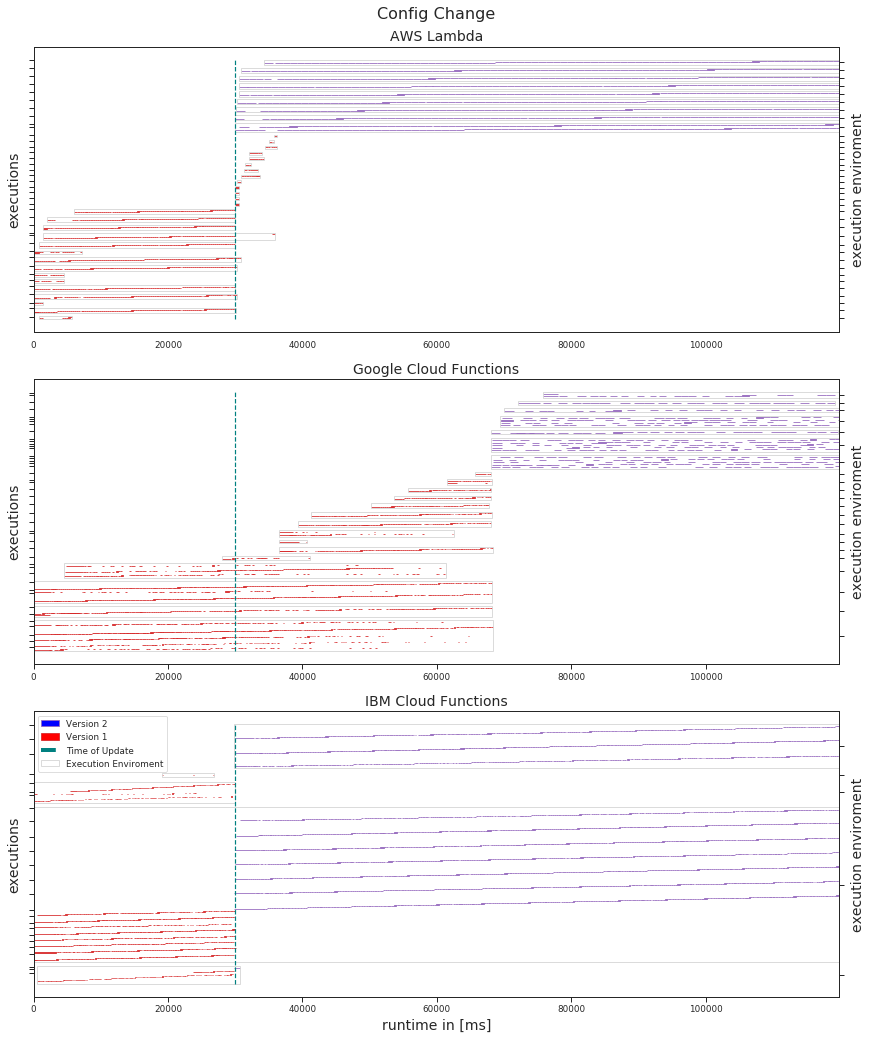

In [640]:

fig = plt.figure(constrained_layout=True,figsize=(12,14))
gs = GridSpec(3, 1, figure=fig)
colors = nb_colors[3:5]

xmax = 0
for title, sample in config.items():
    xmax = max(sample.elapsed_time.max(),xmax)

cnt = 0
for title, sample in config.items():
    ax = fig.add_subplot(gs[cnt, 0])
    violinPlot(sample,title,ax,colors,param="config",delta=50,fontsize=14,ylabel='executions',yylabel='execution enviroment')
    ax.set_xlim(-5,xmax*1000)
    cnt+=1



ax.set_xlabel("runtime in [ms]",fontsize=14)
my_suptitle = fig.suptitle('Config Change', fontsize=16,y=1.02)
    
legend_elements = [Patch(facecolor='b', edgecolor=colors[1],label='Version 2'),
                   Patch(facecolor='r', edgecolor=colors[0],label='Version 1'),
                   Line2D([0], [1], color='teal',linestyle='--', lw=4, label='Time of Update'),
                   Patch(fill=False,edgecolor="lightgray",label="Execution Enviroment")]
ax.legend(handles=legend_elements)
fig.savefig('../report/Paper/resources/images/config_change.eps',bbox_inches='tight',bbox_extra_artists=[my_suptitle])
plt.show()

In [8]:
ncode = {L_AWS:aws,L_Azure%"Windows":azw}
nconfig = {L_GCF:prepare_data(gcloudConfig),L_IBM:prepare_data(ibmConfig)}

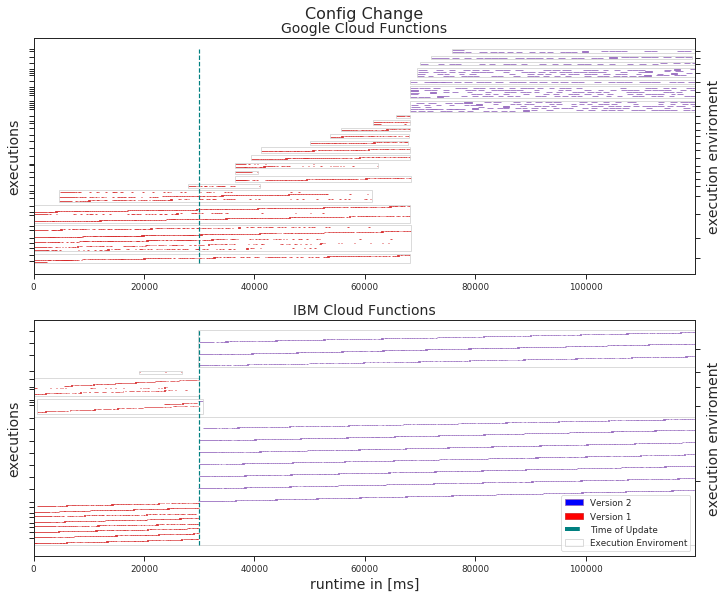

In [10]:
fig = plt.figure(constrained_layout=True,figsize=(10,8))
gs = GridSpec(2, 1, figure=fig)
colors = nb_colors[3:5]




xmax = 0
for title, sample in nconfig.items():
    xmax = max(sample.elapsed_time.max(),xmax)

cnt = 0
for title, sample in nconfig.items():
    ax = fig.add_subplot(gs[cnt, 0])
    violinPlot(sample,title,ax,colors,param="config",delta=50,fontsize=14,ylabel='executions',yylabel='execution enviroment')
    ax.set_xlim(-5,xmax*1000)
    cnt+=1



ax.set_xlabel("runtime in [ms]",fontsize=14)
my_suptitle = fig.suptitle('Config Change', fontsize=16,y=1.02)
    
legend_elements = [Patch(facecolor='b', edgecolor=colors[1],label='Version 2'),
                   Patch(facecolor='r', edgecolor=colors[0],label='Version 1'),
                   Line2D([0], [1], color='teal',linestyle='--', lw=4, label='Time of Update'),
                   Patch(fill=False,edgecolor="lightgray",label="Execution Enviroment")]
ax.legend(handles=legend_elements)
fig.savefig('../report/Paper/resources/images/config_change.eps',bbox_inches='tight',bbox_extra_artists=[my_suptitle])
plt.show()

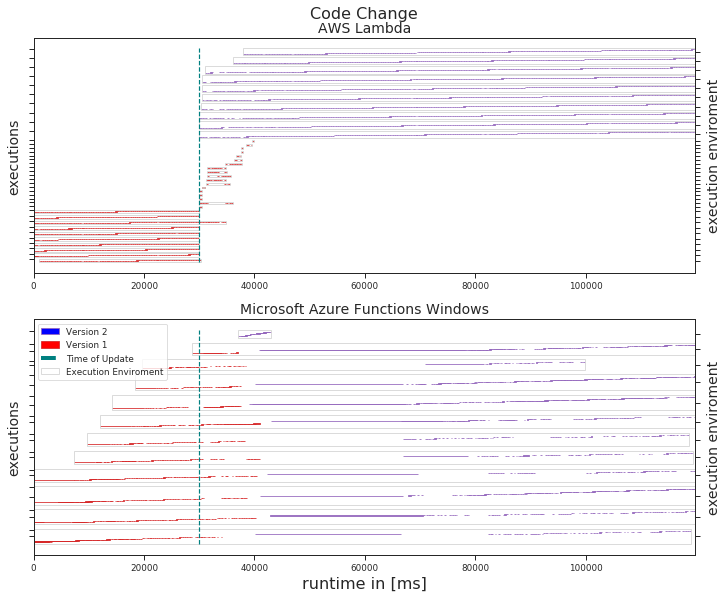

In [12]:
fig = plt.figure(constrained_layout=True,figsize=(10,8))
gs = GridSpec(2, 1, figure=fig)
colors = nb_colors[3:5]

xmax = 0
for title, sample in ncode.items():
    xmax = max(sample.elapsed_time.max(),xmax)

cnt = 0
for title, sample in ncode.items():
    ax = fig.add_subplot(gs[cnt, 0])
    violinPlot(sample,title,ax,colors,delta=50,fontsize=14,ylabel='executions',yylabel='execution enviroment')
    ax.set_xlim(-5,xmax*1000)
    cnt+=1

ax.set_xlabel("runtime in [ms]",fontsize=16)
my_suptitle = fig.suptitle('Code Change', fontsize=16,y=1.02)
    
legend_elements = [Patch(facecolor='b', edgecolor=colors[1],label='Version 2'),
                   Patch(facecolor='r', edgecolor=colors[0],label='Version 1'),
                   Line2D([0], [1], color='teal',linestyle='--', lw=4, label='Time of Update'),
                   Patch(fill=False,edgecolor="lightgray",label="Execution Enviroment")]
ax.legend(handles=legend_elements)
fig.savefig('../report/Paper/resources/images/code_change.eps',bbox_inches='tight',bbox_extra_artists=[my_suptitle])
plt.show()

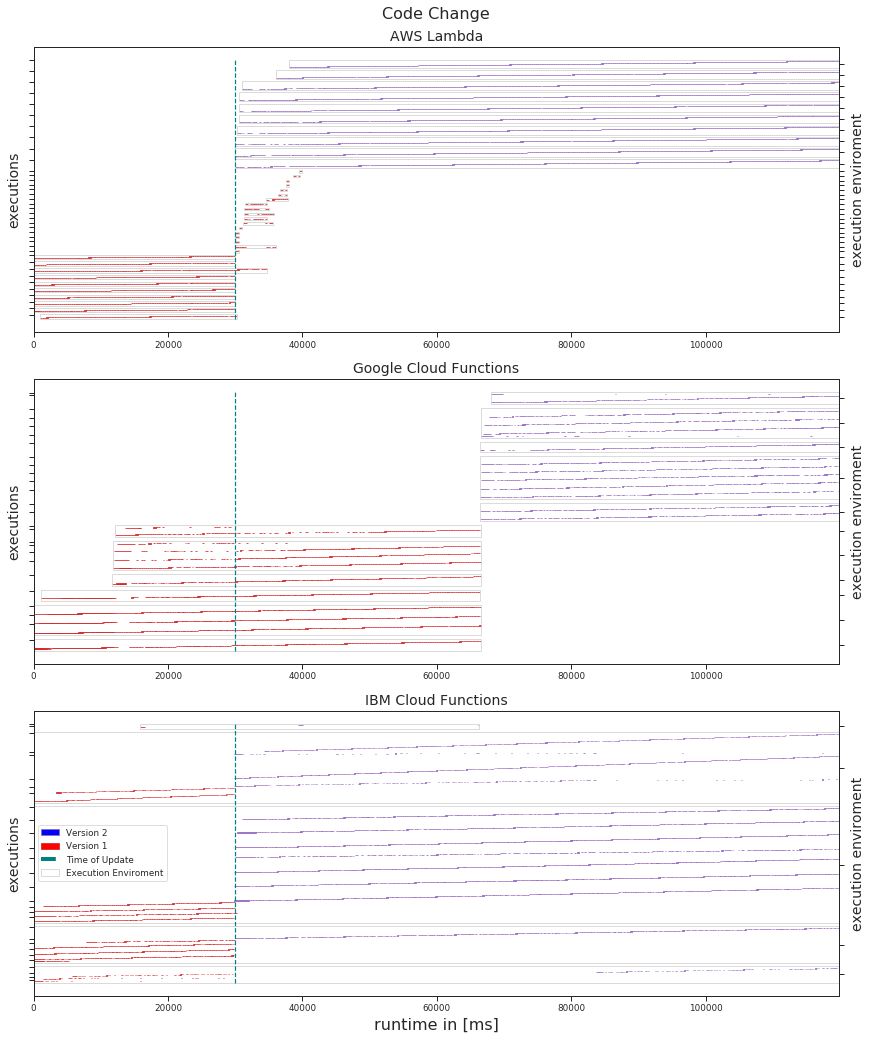

In [641]:
fig = plt.figure(constrained_layout=True,figsize=(12,14))
gs = GridSpec(3, 1, figure=fig)
colors = nb_colors[3:5]

xmax = 0
for title, sample in code.items():
    xmax = max(sample.elapsed_time.max(),xmax)

cnt = 0
for title, sample in code.items():
    ax = fig.add_subplot(gs[cnt, 0])
    violinPlot(sample,title,ax,colors,delta=50,fontsize=14,ylabel='executions',yylabel='execution enviroment')
    ax.set_xlim(-5,xmax*1000)
    cnt+=1

ax.set_xlabel("runtime in [ms]",fontsize=16)
my_suptitle = fig.suptitle('Code Change', fontsize=16,y=1.02)
    
legend_elements = [Patch(facecolor='b', edgecolor=colors[1],label='Version 2'),
                   Patch(facecolor='r', edgecolor=colors[0],label='Version 1'),
                   Line2D([0], [1], color='teal',linestyle='--', lw=4, label='Time of Update'),
                   Patch(fill=False,edgecolor="lightgray",label="Execution Enviroment")]
ax.legend(handles=legend_elements)
fig.savefig('../report/Paper/resources/images/code_change.eps',bbox_inches='tight',bbox_extra_artists=[my_suptitle])
plt.show()

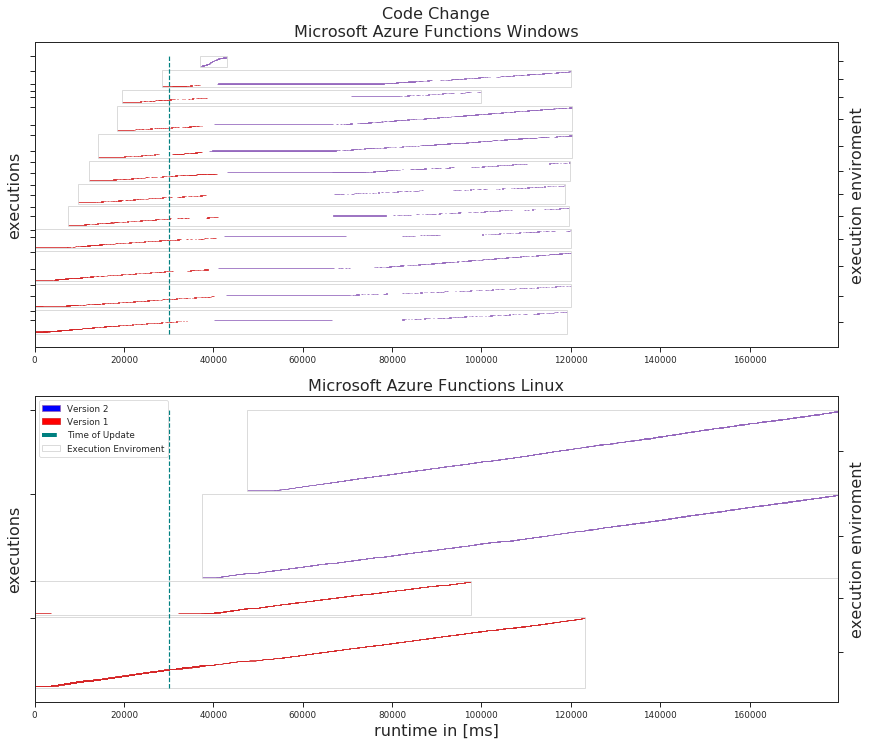

In [642]:
fig = plt.figure(constrained_layout=True,figsize=(12,10))
gs = GridSpec(2, 1, figure=fig)
colors = nb_colors[3:5]
cnt = 0
xmax = 0
for title, sample in azure.items():
    xmax = max(sample.elapsed_time.max(),xmax)
    
for title, sample in azure.items():
    ax = fig.add_subplot(gs[cnt, :])
    violinPlot(sample,title,ax,colors,delta=15,fontsize=16,ylabel='executions',yylabel='execution enviroment')
    ax.set_xlim(0,xmax*1000)
    cnt+=1



ax.set_xlabel("runtime in [ms]",fontsize=16)
my_suptitle = fig.suptitle('Code Change', fontsize=16,y=1.02)
    
legend_elements = [Patch(facecolor='b', edgecolor=colors[1],label='Version 2'),
                   Patch(facecolor='r', edgecolor=colors[0],label='Version 1'),
                   Line2D([0], [1], color='teal',linestyle='--', lw=4, label='Time of Update'),
                   Patch(fill=False,edgecolor="lightgray",label="Execution Enviroment")]
ax.legend(handles=legend_elements)
fig.savefig('../report/Paper/resources/images/azur_change.eps',bbox_inches='tight',bbox_extra_artists=[my_suptitle])
plt.show()

## Tables

In [9]:
def lastResponse(data,change_time=30):
    '''get the last time after the change event that a old version responded '''
    Y = ((data.loc[data['version'] == '1'][['elapsed_time','latency']]*[1000,1]).sum(axis=1).max())/1000
    return max((Y-change_time),0)
# calc visibility window
def firstDeploy(data,change_time=30):
    '''get the first time after the change event that a new version run'''
    Y = ((data.loc[data['version'] == '2'][['elapsed_time','latency']]*[1000,0]).sum(axis=1).min())/1000
    return (Y-change_time)

In [10]:
def inconsistancyWindow(data,change_time=30):
    
    X = ((data.loc[data['version'] == '1'][['elapsed_time','latency']]*[1000,1]).sum(axis=1).max())/1000
    # first deploy
    Y = ((data.loc[data['version'] == '2'][['elapsed_time','latency']]*[1,0]).sum(axis=1).min())
    return X-Y


In [11]:
def findStabilisationPoint(data,plot=False):
    #time of first change 
    t0 = (data.loc[data['version'] == '2']['elapsed_time']).min()

    #last event
    tn = data['elapsed_time'].max()

    #get the data that we are interested in
    change = data[data['elapsed_time'].between(t0,tn)][['version','elapsed_time','latency']]
    change = change[change['version'] == '2'][['elapsed_time','latency']]
    
    #normalize the latancy
    change = change/[1,change['latency'].mean()]
    #split the searchspace into equal parts
    windowSize = math.floor(round(len(change)/80))
    plot_data = []
    #collect variance per window
    for i in range(0,len(change),windowSize):
        window = change[i:i+windowSize]
        if not np.isnan(window['latency'].var()):
            plot_data.append(window['latency'].var())
    #find the varaiance that indicates an non stable windwo (mean variance+offset)
    delta = np.mean(plot_data)+np.std(plot_data)
    if plot:
        plt.plot(range(0,len(plot_data)),plot_data)
        plt.plot(range(0,len(plot_data)),[delta]*len(plot_data))
    
    sMax = tn
    for i in range(0,len(change),windowSize):
        window = change[i:i+windowSize]
        if window['latency'].var() >= delta:
            sMax = min(window['elapsed_time'].max(),sMax)
    #if no point could be found we return the last possible time
    return sMax

In [19]:
def perf(data):
    ''' mean latancy during change t0 (first detected change) - t0+window'''
    t0 = (data.loc[data['version'] == '2']['elapsed_time']).min()
    t1 = findStabilisationPoint(data)
    stable = data[(data['elapsed_time'] > t1)][data['version'] == '2']
    change = data[data['elapsed_time'].between(t0,t1,inclusive=False)][data['version'] == '2']
    q09 = change['latency'].quantile(0.9),stable['latency'].quantile(0.9)
    q99 = change['latency'].quantile(0.99),stable['latency'].quantile(0.99)
    m = change['latency'].max(),stable['latency'].max()
    return q09,q99,m

def failure(data,change_time=30):
    change = data[(data['elapsed_time'] > change_time)]
    return change[change['statusCode'] >=400]['latency'].count()

def earleastDetectionTime(data,change_time=30):
    '''get the last time after the change event that a old version responded (start_time+latancy)'''
    Y = ((data.loc[data['version'] == '2'][['elapsed_time','latency']]*[1000,1]).sum(axis=1).min())/1000.0
    return (Y-change_time)

def meantimeToCompensation(data,change_time=30):
    Y = ((data.loc[data['version'] == '1'][['elapsed_time','latency']]*[1000,0]).sum(axis=1).max())/1000
    return Y-change_time+earleastDetectionTime(data,change_time)

In [14]:
rows=["inconsistency window [s]","last response (v1) [s]","first deployment (v2) [s]","p90 latency (during/after) [ms]",
     "p99 latency (during/after) [ms]" ,"max latency (during/after) [ms]", "failed requests [\#]","error detection [s]","error compensation [s]"]

In [20]:

names = list(map(shortName,({**code, **azure}.keys())))
code_qualities = []

for n,d in {**code, **azure}.items():
    perfs = perf(d)
    row = [
        "%.2f"%inconsistancyWindow(d),
        "%.2f"%lastResponse(d),
        "%.2f"%firstDeploy(d),
        "%.0f, %.0f"%perfs[0],
        "%.0f, %.0f"%perfs[1],
        "%.0f, %.0f"%perfs[2],
        failure(d),
        "%.2f"%earleastDetectionTime(d),
        "%.2f"%meantimeToCompensation(d),
    ]
    
    code_qualities.append(row)



code_qualities = pd.DataFrame(code_qualities,columns=rows,index=names).T
code_qualities

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,AWS,GCF,ICF,MAF (Win.),MAF (Linux)
inconsistency window [s],10.01,0.21,0.41,3.83,85.85
last response (v1) [s],9.96,36.63,0.22,10.96,93.26
first deployment (v2) [s],-0.05,36.42,-0.19,7.13,7.41
p90 latency (during/after) [ms],"480, 344","1749, 331","2422, 299","437, 586","507, 837"
p99 latency (during/after) [ms],"549, 435","1864, 576","4214, 401","20324, 1638","576, 1140"
max latency (during/after) [ms],"550, 778","1877, 1246","4318, 907","28440, 37340","586, 6224"
failed requests [\#],0,0,0,0,0
error detection [s],0.50,36.87,0.96,7.96,10.82
error compensation [s],10.00,73.18,0.70,17.96,103.78


In [22]:
with open('../report/Paper/resources/data/codeChangeStats.tex','w') as f:
    f.write(code_qualities.to_latex(index=rows,escape=False))

In [21]:
names = list(map(shortName,(config.keys())))
config_qualiteis = []
#fix interface 
for d in config.values():
    d['version'] = d['config']
    
for n,d in config.items():
    perfs = perf(d)
    row = [
        "%.2f"%inconsistancyWindow(d),
        "%.2f"%lastResponse(d),
        "%.2f"%firstDeploy(d),
        "%.0f, %.0f"%perfs[0],
        "%.0f, %.0f"%perfs[1],
        "%.0f, %.0f"%perfs[2],
        failure(d),
        "%.2f"%earleastDetectionTime(d),
        "%.2f"%meantimeToCompensation(d),
    ]
    
    config_qualiteis.append(row)



config_qualiteis = pd.DataFrame(config_qualiteis,columns=rows,index=names).T
config_qualiteis

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,AWS,GCF,ICF
inconsistency window [s],6.28,0.25,0.23
last response (v1) [s],6.25,38.36,0.07
first deployment (v2) [s],-0.04,38.11,-0.16
p90 latency (during/after) [ms],"1484, 1138","1591, 1398","3074, 427"
p99 latency (during/after) [ms],"1494, 1184","2405, 2133","4028, 546"
max latency (during/after) [ms],"1495, 1492","2498, 3223","4360, 800"
failed requests [\#],0,0,0
error detection [s],1.36,39.36,0.67
error compensation [s],7.31,77.43,0.46


In [23]:
with open('../report/Paper/resources/data/configChangeStats.tex','w') as f:
    f.write(config_qualiteis.to_latex(index=rows,escape=False))

## Deprecated Plots

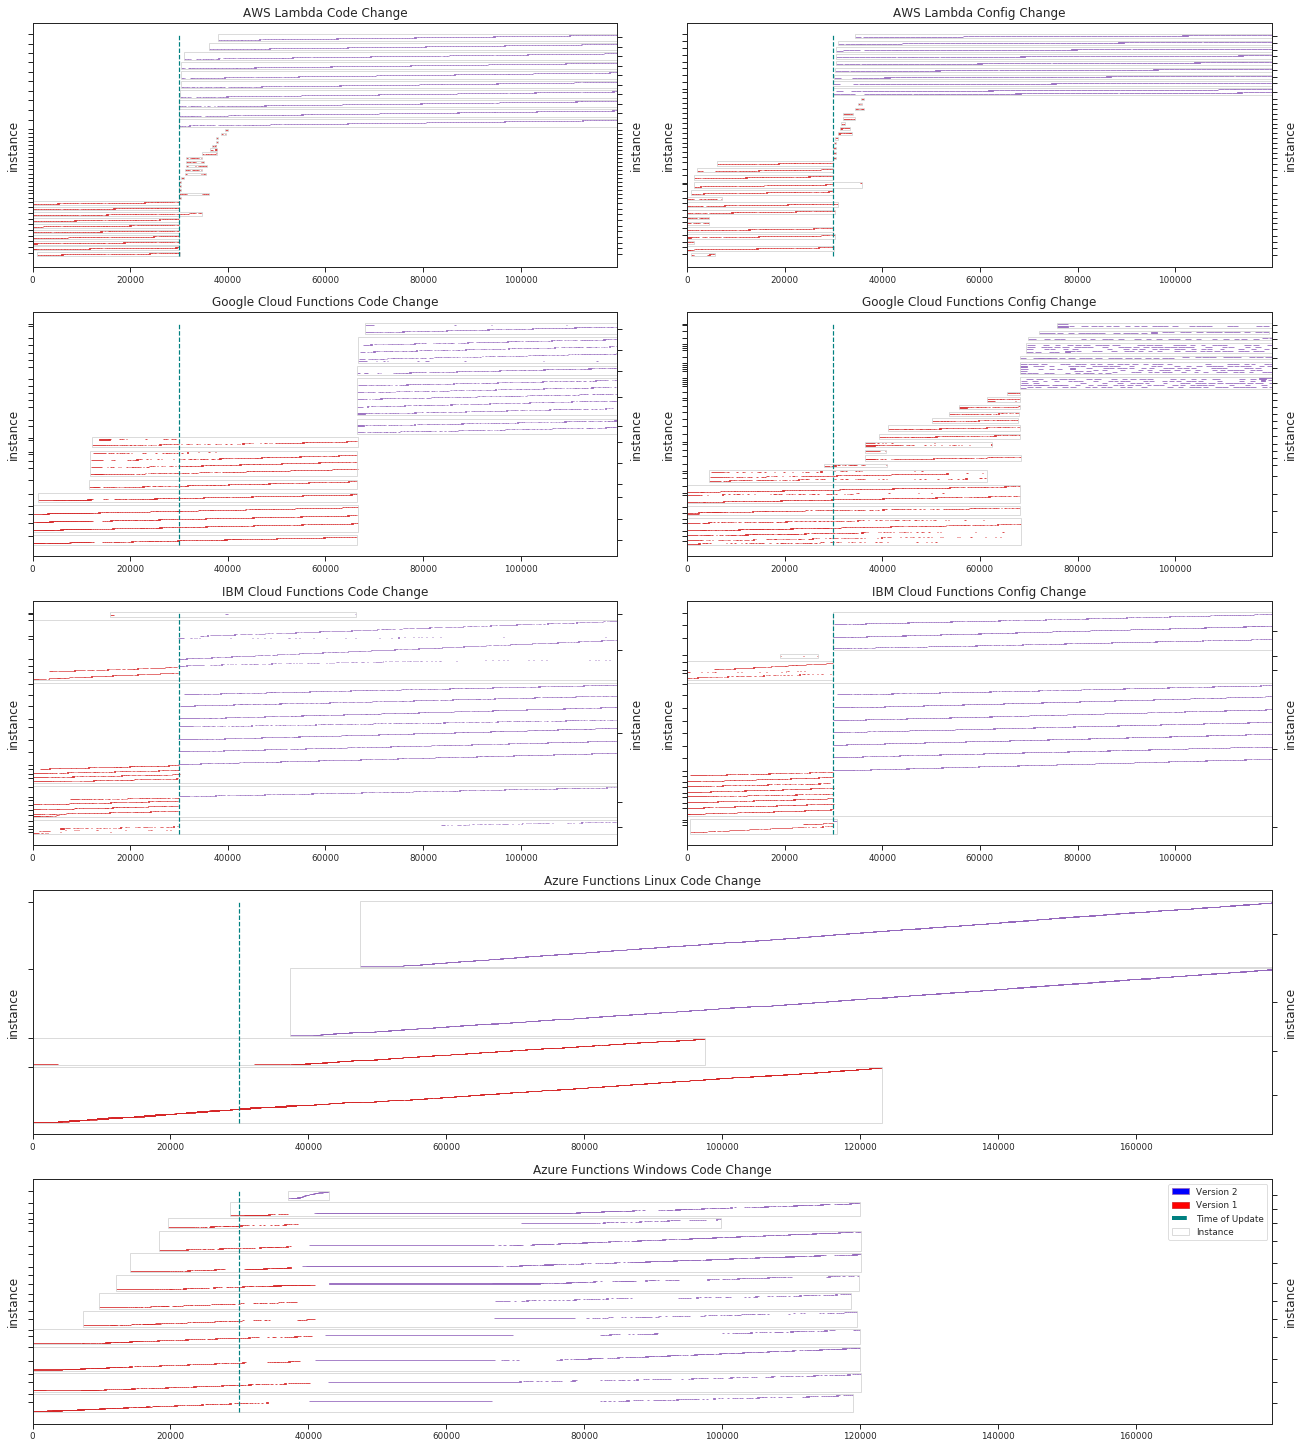

In [444]:
fig = plt.figure(constrained_layout=True,figsize=(18,20))
gs = GridSpec(5, 2, figure=fig)
colors = nb_colors[3:5]
xmax = 0
for title, sample in config.items():
    xmax = max(sample.elapsed_time.max(),xmax)

cnt = 0
for title, sample in config.items():
    ax = fig.add_subplot(gs[cnt, 1])
    violinPlot(sample,title+" Config Change",ax,colors,param="config",delta=50)
    ax.set_xlim(-5,xmax*1000)
    cnt+=1

xmax = 0
for title, sample in code.items():
    xmax = max(sample.elapsed_time.max(),xmax)

cnt = 0
for title, sample in code.items():
    ax = fig.add_subplot(gs[cnt, 0])
    violinPlot(sample,title+" Code Change",ax,colors,delta=50)
    ax.set_xlim(-5,xmax*1000)
    cnt+=1

xmax = 0
for title, sample in azure.items():
    xmax = max(sample.elapsed_time.max(),xmax)
    
for title, sample in azure.items():
    ax = fig.add_subplot(gs[cnt, :])
    violinPlot(sample,title+" Code Change",ax,colors,delta=15)
    ax.set_xlim(0,xmax*1000)
    cnt+=1





    
legend_elements = [Patch(facecolor='b', edgecolor=colors[1],label='Version 2'),
                   Patch(facecolor='r', edgecolor=colors[0],label='Version 1'),
                   Line2D([0], [1], color='teal',linestyle='--', lw=4, label='Time of Update'),
                   Patch(fill=False,edgecolor="lightgray",label="Instance")]
ax.legend(handles=legend_elements)
fig.savefig('../report/Paper/resources/images/performance.eps')
plt.show()

AWS Lambda Change average latency is 321.96
AWS LambdaConfiguration Change average latency is 668.84
Google Cloud Functions Code Change average latency is 333.63
Google Cloud Functions Configuration Change average latency is 494.51
IBM Cloud Functions Code Change average latency is 216.16
IBM Cloud Functions Configuration Change average latency is 293.69
Azure Functions Linux Code Change average latency is 528.14
Azure Functions Windows Code Change average latency is 591.45


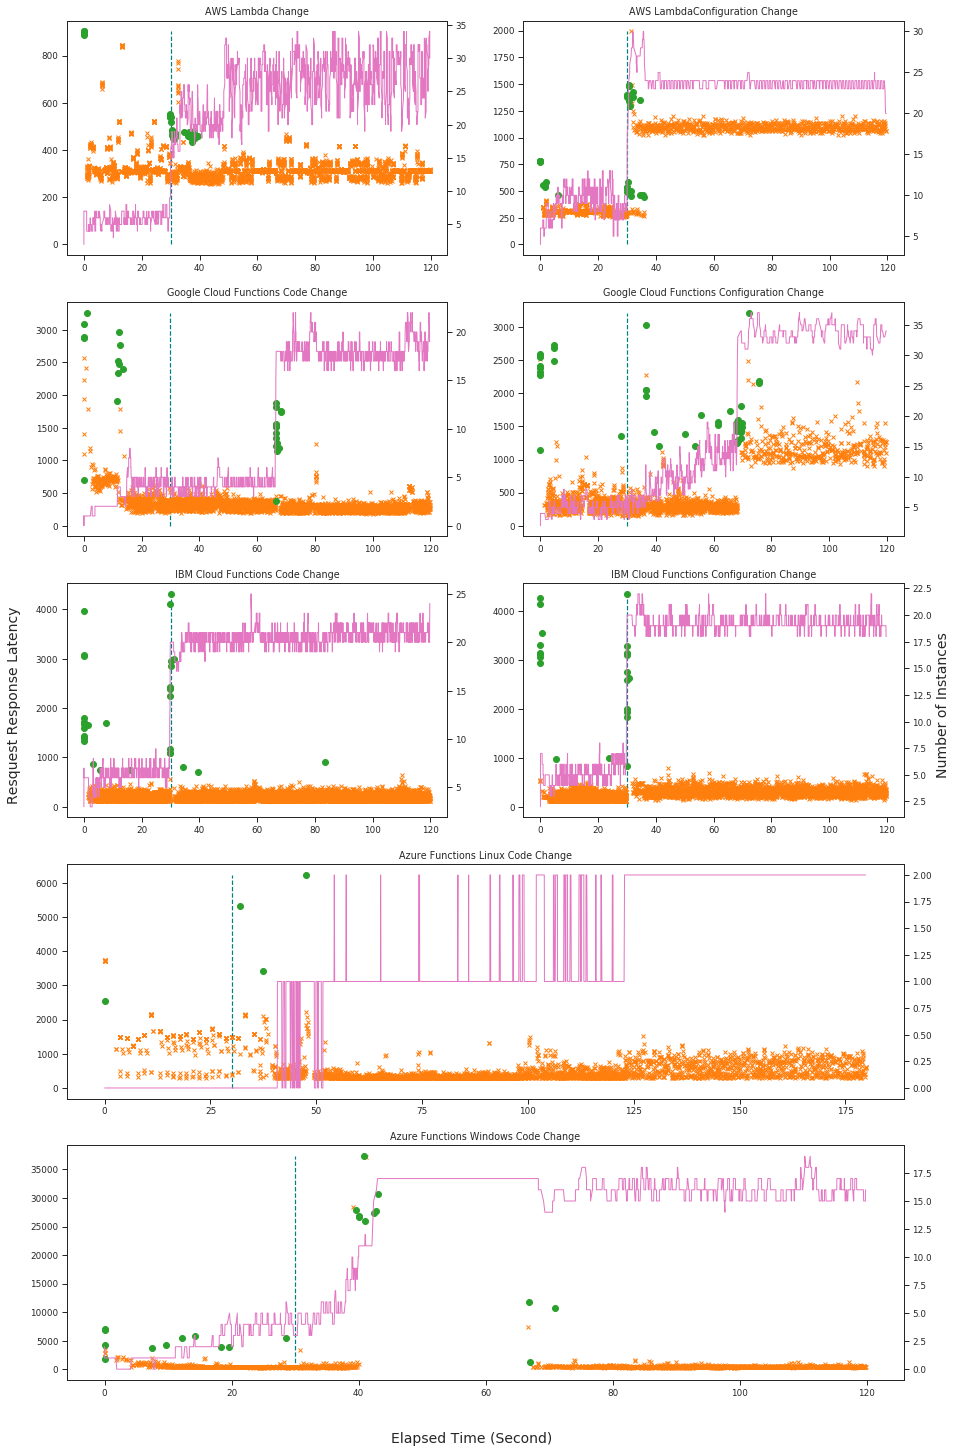

In [445]:
csvHeader=['timestamp', 'latency', 'protocol', 'code', 'status', 'thread', 'response' , 'version','value','latency2','statusCode','vm_id','boot_time','memory', 'timeout']

awsCode = pd.read_csv('AWS/Results/aws-results-code.csv', names=csvHeader)
awsConfig = pd.read_csv('AWS/Results/aws-results-config.csv', names=csvHeader)

gcloudCode = pd.read_csv('Google/Results/gcloud-results-code.csv', names=csvHeader)
gcloudConfig = pd.read_csv('Google/Results/gcloud-results-config.csv', names=csvHeader)

ibmCode = pd.read_csv('IBM/Results/ibm-results-code.csv', names=csvHeader)
ibmConfig = pd.read_csv('IBM/Results/ibm-results-config.csv', names=csvHeader)

azureCodeLinux = pd.read_csv('Azure/Results/azure-linux-results-code.csv', names=csvHeader)
azureCodeWindows = pd.read_csv('Azure/Results/azure-windows-results-code.csv', names=csvHeader) 


awsCode = prepare_data(awsCode)
awsConfig = prepare_data(awsConfig)
gcloudCode = prepare_data(gcloudCode)
gcloudConfig = prepare_data(gcloudConfig)
ibmCode = prepare_data(ibmCode)
ibmConfig = prepare_data(ibmConfig)
azureCodeLinux = prepare_data(azureCodeLinux)
azureCodeWindows = prepare_data(azureCodeWindows)

codeFig , codef = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(15, 25))

codeFig.text(0.5, 0.09, 'Elapsed Time (Second)', ha='center', fontsize=14)
codeFig.text(0.07, 0.5, 'Resquest Response Latency', va='center', rotation='vertical', fontsize=14)
codeFig.text(0.93, 0.5, 'Number of Instances', va='center', rotation='vertical',fontsize=14)

#Plot AWS Code Change
plot = plt.subplot(5,2,1)
plot_data(awsCode,L_AWS+" Change",plot)
#Plot AWS Config Change
plot = plt.subplot(5,2,2)
plot_data(awsConfig,L_AWS+"Configuration Change",plot)

#Plot Gcloud Code Change
plot = plt.subplot(5,2,3)
plot_data(gcloudCode,L_GCF+" Code Change",plot)

#Plot Gcloud Config Change
plot = plt.subplot(5,2,4)
plot_data(gcloudConfig,L_GCF+" Configuration Change",plot)

# #Plot IBM Code Change
# plot = plt.subplot(5,2,5)
# plot_data(ibmCodeNode6,"IBM Cloud Functions Code Change",plot)

# #Plot IBM Config Change
# plot = plt.subplot(5,2,6)
# plot_data(ibmConfigNode6,"IBM Cloud Functions Configuration Change",plot)

#Plot IBM Node8 Code Change
plot = plt.subplot(5,2,5)
plot_data(ibmCode,L_IBM+" Code Change",plot)

#Plot IBM  Node8  Config Change
plot = plt.subplot(5,2,6)
plot_data(ibmConfig,L_IBM+" Configuration Change",plot)
#Plot Azure 

plot = plt.subplot(5,1,4)
plot_data(azureCodeLinux,L_Azure%"Linux"+" Code Change",plot)

plot = plt.subplot(5,1,5)
plot_data(azureCodeWindows,L_Azure%"Windows"+" Code Change",plot)
plt.rcParams.update({'font.size': 12})
plt.show()

#codeFig.savefig('../report/Paper/resources/images/performance.png')

AWS Lambda time to propagate is -0.048
Google Cloud Functions time to propagate is 36.42
IBM Cloud Functions time to propagate is -0.188
Azure Functions Linux time to propagate is 7.408
Azure Functions Windows time to propagate is 7.127


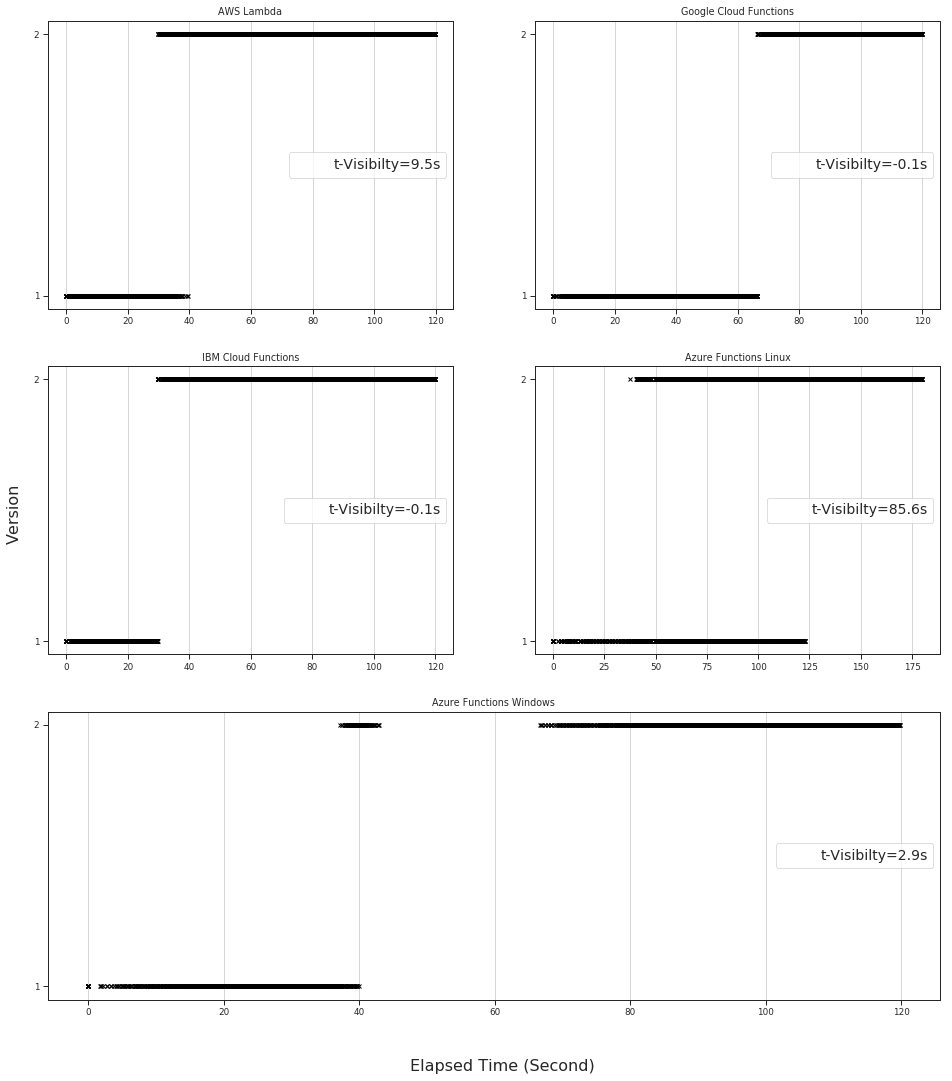

In [446]:
versionFig , b = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(16, 18))

versionFig.text(0.52, 0.07, 'Elapsed Time (Second)', ha='center', fontsize=16)
versionFig.text(0.09, 0.5, 'Version', va='center', rotation='vertical', fontsize=16)

plot_staleness(awsCode,L_AWS,plt.subplot(3,2,1))
plot_staleness(gcloudCode,L_GCF,plt.subplot(3,2,2))
plot_staleness(ibmCode,L_IBM,plt.subplot(3,2,3))
plot_staleness(azureCodeLinux,L_Azure%"Linux",plt.subplot(3,2,4))
plot_staleness(azureCodeWindows,L_Azure%"Windows",plt.subplot(3,1,3))
plt.rcParams.update({'font.size': 17})
plt.show()

versionFig.savefig('../report/Paper/resources/images/tvisibility.png')


AWS Lambda time to propagate is -0.036
Google Cloud Functions time to propagate is 38.113
IBM Cloud Functions time to propagate is -0.165


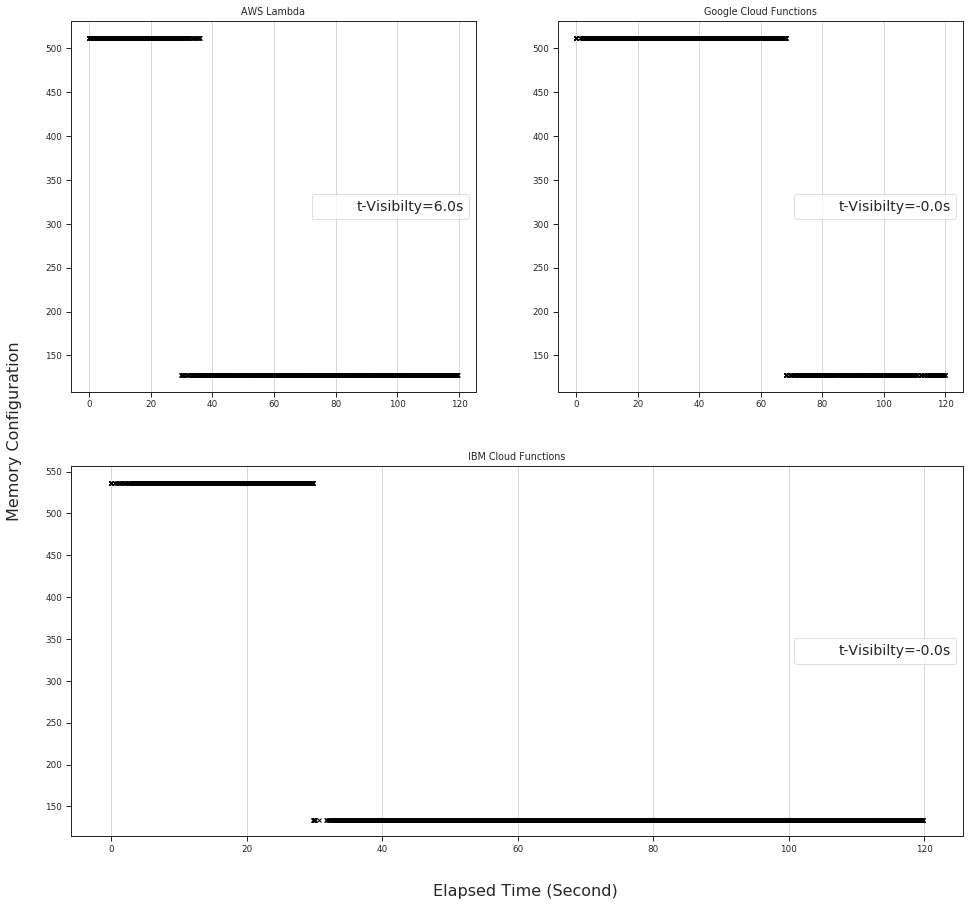

In [447]:
versionFig , b = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16, 15))

versionFig.text(0.52, 0.07, 'Elapsed Time (Second)', ha='center', fontsize=16)
versionFig.text(0.07, 0.5, 'Memory Configuration', va='center', rotation='vertical', fontsize=16)

plot_staleness_config(awsConfig,L_AWS,plt.subplot(2,2,1),'memory')
plot_staleness_config(gcloudConfig,L_GCF,plt.subplot(2,2,2),'memory')
plot_staleness_config(ibmConfig,L_IBM,plt.subplot(2,1,2),'memory')

plt.rcParams.update({'font.size': 17})
plt.show()

AWS Lambda time to propagate is 1.362
Google Cloud Functions time to propagate is 38.113
IBM Cloud Functions time to propagate is -0.081


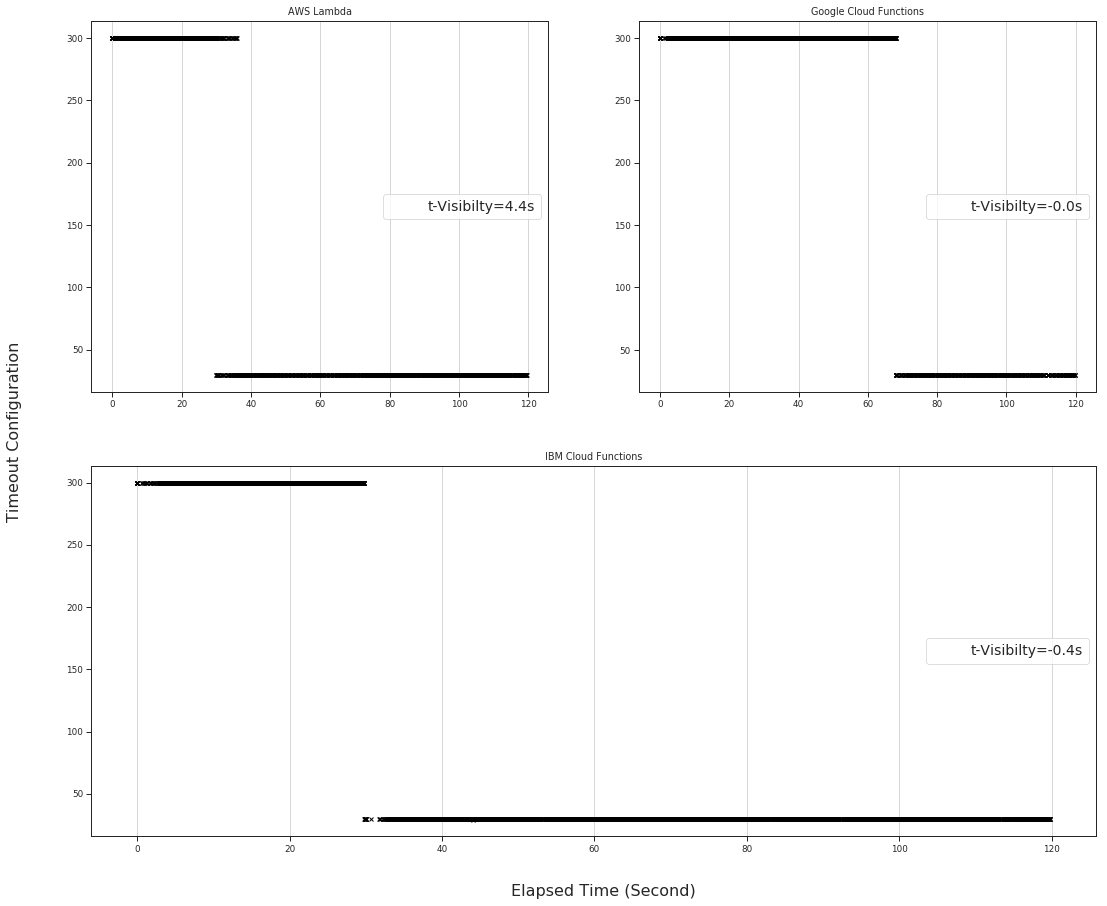

In [448]:
versionFig , b = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(18, 15))

versionFig.text(0.52, 0.07, 'Elapsed Time (Second)', ha='center', fontsize=16)
versionFig.text(0.06, 0.5, 'Timeout Configuration', va='center', rotation='vertical', fontsize=16)

plot_staleness_config(awsConfig,L_AWS,plt.subplot(2,2,1),'timeout')
plot_staleness_config(gcloudConfig,L_GCF,plt.subplot(2,2,2),'timeout')
plot_staleness_config(ibmConfig,L_IBM,plt.subplot(2,1,2),'timeout')

plt.rcParams.update({'font.size': 17})
plt.show()

In [449]:
def violinPlot_old(data,title,ax,group="instance",delta=15):
    ax.grid(False)

    inst = sorted(data[group].unique())
    
    low = data.timestamp.min()
    cl = nb_colors[3:5]
    offset = 0
    ticks = []
    labels = []
    
    #draw rects for each 
    for j in inst:
        sample = data[data[group] == j]
        size = len(sample)
        for i in range(size):
            d = sample.iloc[i]
            start = d.timestamp-low
            ax.add_patch(patches.Rectangle((start,i+offset),d.latency,0.8,color=cl[int(d.version)-1]))
        ticks.append(offset+np.math.floor(size/2))
        labels.append(j)
        offset += size
        offset += delta

    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    ax.set_ylabel(group+"id")
    ax.set_title(title)
    
    #force autosizing for auto sizing of the plot
    ax.plot((0,offset),(0,0),color="none",linestyle='')
    #draw version change
    ax.vlines(30000,0,offset,linestyles='dashed',color="teal")

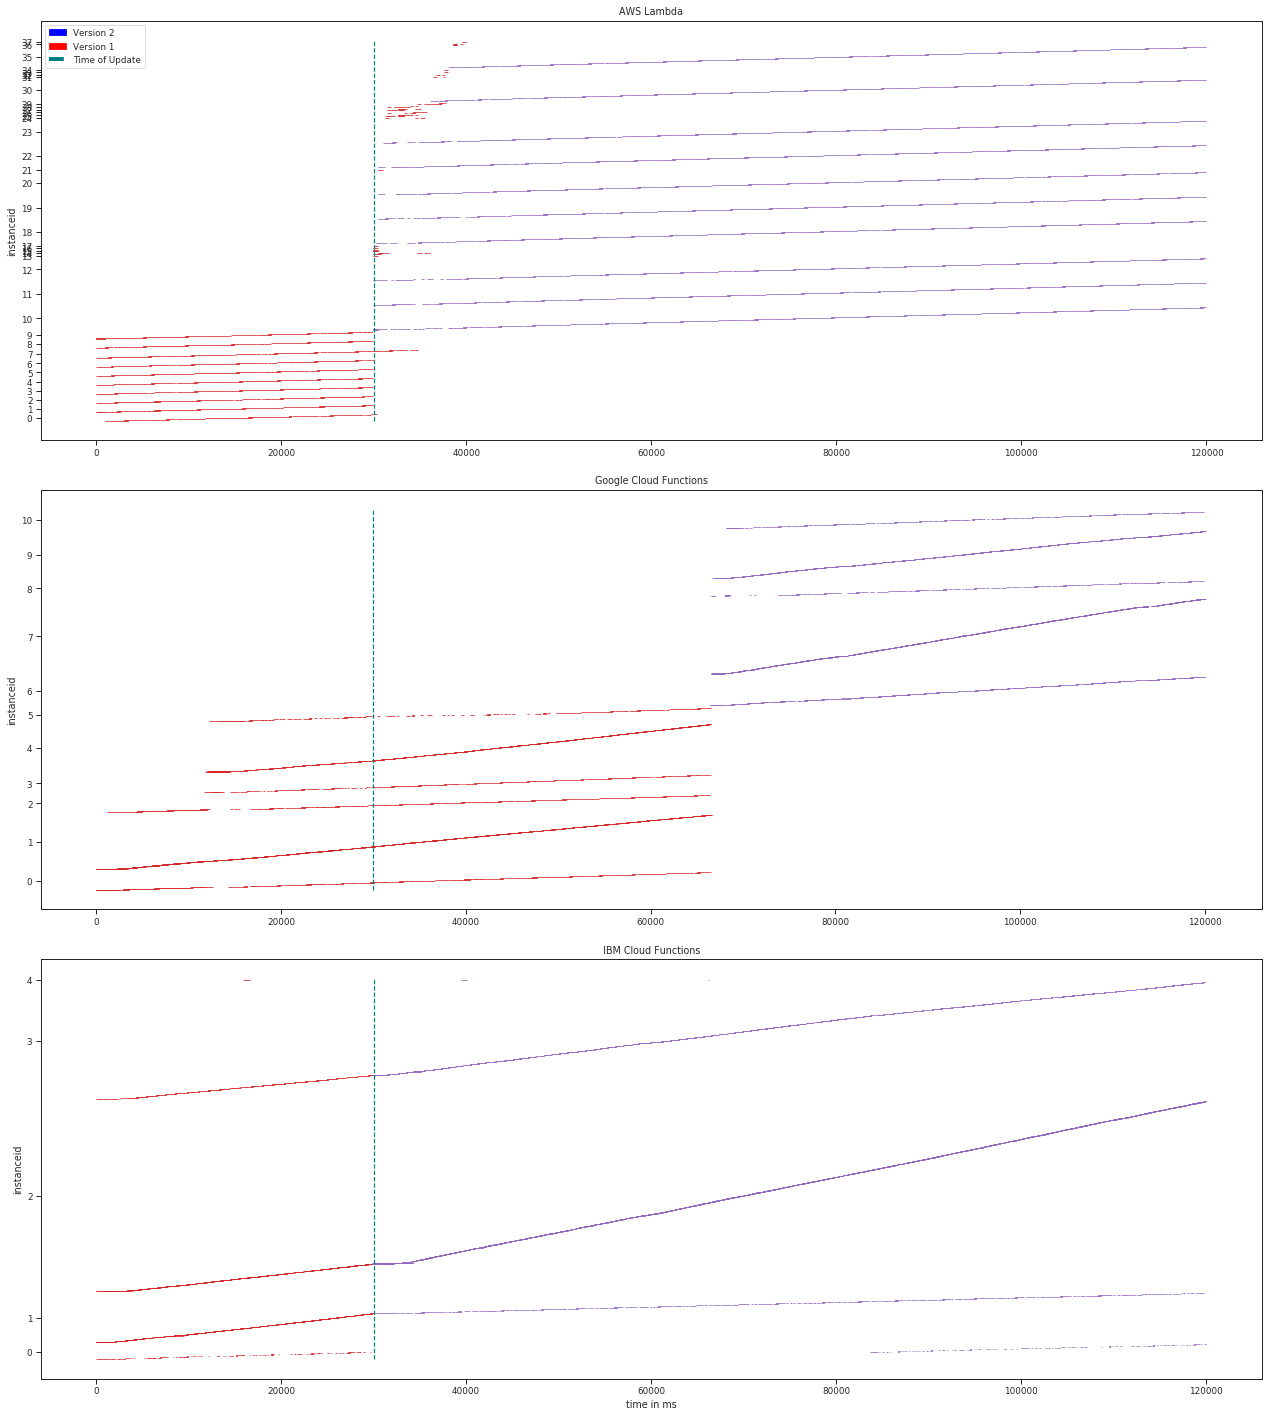

In [451]:
data = code
violinPlot = violinPlot_old
fig,ax = plt.subplots(nrows=len(data),ncols=1,figsize=(18,20))

xmax = 0
for title, sample in data.items():
    xmax = max(sample.elapsed_time.max(),xmax)

cnt = 0
for title, sample in data.items():
    violinPlot(sample,title,ax[cnt],delta=30)
    #fix x-axis to one length
    #ax[cnt].set_xlim(0,xmax*1000)
    cnt+=1
    
legend_elements = [Patch(facecolor='b', edgecolor='b',label='Version 2'),
                   Patch(facecolor='r', edgecolor='r',label='Version 1'),
                   Line2D([0], [0], color='teal',linestyle='--', lw=4, label='Time of Update')]

ax[0].legend(handles=legend_elements)
ax[-1].set_xlabel("time in ms")
plt.tight_layout()